**Program to simulate the 2-dimensional lattice gas with swap updates**

In [11]:
  # Adjustable simulation parameters
L = 50  # Lattice size
T = 0.4  # Temperature
n_sweeps_eq = 100  # Number of sweeps to equilibrate
n_sweeps_per_meas = 10  # Sweeps between measurements
n_meas = 500  # Number of measurements
print(f"Temperature=",T,"L=",L)   # Echo run parameters
print(f"Number of equiibrations sweeps",n_sweeps_eq)
print(f"Number of sweeps between each measurement",n_sweeps_per_meas)
print(f"Number of measurements",n_meas)

Temperature= 0.4 L= 50
Number of equiibrations sweeps 100
Number of sweeps between each measurement 10
Number of measurements 500


Import required libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse  # Added for command-line argument parsing
from numba import njit  # For just-in-time compilation to speed up performance-critical functions

Define nearest-neighbor directions (up, down, left, right)

In [13]:
NEIGHBORS = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

Compute the energy change resulting from swapping two particles

In [14]:
@njit
def delta_energy(lattice, L, i1, j1, i2, j2):
    n1 = lattice[i1, j1]
    n2 = lattice[i2, j2]
    s1 = 0
    s2 = 0
    # Compute the sum of neighbors for each site
    for d in NEIGHBORS:
        ii1 = (i1 + d[0]) % L
        jj1 = (j1 + d[1]) % L
        s1 += lattice[ii1, jj1]
        ii2 = (i2 + d[0]) % L
        jj2 = (j2 + d[1]) % L
        s2 += lattice[ii2, jj2]
    # Return the energy difference caused by swapping
    return (n1 - n2) * (s1 - s2)

Perform a Metropolis sweep using pre-generated indices of swap sites

In [15]:
@njit
def sweep_with_indices(lattice, L, T, indices):
    accepted = 0
    attempted = 0
    for i in range(indices.shape[0]):
        i1, j1, i2, j2 = indices[i]
        dE = delta_energy(lattice, L, i1, j1, i2, j2)
        attempted += 1
        # Accept the swap if it lowers energy or with Boltzmann probability
        if dE <= 0 or np.random.rand() < np.exp(-dE / T):
            tmp = lattice[i1, j1]
            lattice[i1, j1] = lattice[i2, j2]
            lattice[i2, j2] = tmp
            accepted += 1
    return accepted, attempted

Generate valid particle swap pairs avoiding self-swaps and nearest neighbors

In [16]:
def generate_valid_indices(L, n):
    indices = []
    while len(indices) < n:
        i1, j1 = np.random.randint(0, L, 2)
        i2, j2 = np.random.randint(0, L, 2)
        if i1 == i2 and j1 == j2:
            continue
        di = min(abs(i1 - i2), L - abs(i1 - i2))
        dj = min(abs(j1 - j2), L - abs(j1 - j2))
        # Avoid adjacent sites (ensures detailed balance)
        if di + dj == 1:
            continue
        indices.append((i1, j1, i2, j2))
    return np.array(indices, dtype=np.int32)

Compute the structure factor (square of Fourier transform of density fluctuations)

In [17]:
def compute_structure_factor(config):
    rho = config.astype(np.float32) - np.mean(config)
    F = np.fft.fftshift(np.fft.fft2(rho))
    return np.abs(F) ** 2

Compute the radial distribution function g(r)

In [18]:
def compute_rdf(config, n_bins=50):
    L = config.shape[0]
    particles = np.argwhere(config)
    # Compute all pairwise distances
    diffs = particles[:, None, :] - particles[None, :, :]
    diffs = (diffs + L/2) % L - L/2  # Apply periodic boundary conditions
    dists = np.sqrt((diffs**2).sum(axis=2)).ravel()
    edges = np.linspace(0, L/np.sqrt(2), n_bins + 1)
    hist, _ = np.histogram(dists, bins=edges)
    r = 0.5 * (edges[:-1] + edges[1:])
    rho = config.mean()
    dr = edges[1] - edges[0]
    norm = 2 * np.pi * r * dr * rho * len(particles)
    g = hist / norm
    return r, g

------------------ Main Simulation ------------------

In [19]:
import os

In [20]:
if __name__ == "__main__":
    
 # Parse command-line arguments
    live_viz = False
    print(f"Live visualization: {'ON' if live_viz else 'OFF'}")
    plt.ion()  # Interactive mode on for live visualization

    # Initialize lattice with random particle configuration
    density = 0.5  # Initial particle density. Don't change this.
    lattice = (np.random.rand(L, L) < density).astype(np.uint8)

    total_accept = 0
    total_attempt = 0
    accum_energy = 0
    accum_energy_sq = 0
    
    accum_g = None
    accum_S = None

    # Equilibration phase
    for _ in tqdm(range(n_sweeps_eq), desc='Equilibrating'):  #Creates a progress bar 
        indices = generate_valid_indices(L, L * L)
        a, b = sweep_with_indices(lattice, L, T, indices)
        total_accept += a
        total_attempt += b

    # Measurement phase where we at intervals sample observables: the radial distribution function g(r) and the structure factor
    for _ in tqdm(range(n_meas), desc='Sampling'):
        if live_viz:
            plt.clf()
            plt.imshow(lattice, cmap="gray", vmin=0, vmax=1)
            plt.title(f"Lattice (meas step {_})")
            plt.pause(0.001)
        for _ in range(n_sweeps_per_meas):
            indices = generate_valid_indices(L, L * L)
            a, b = sweep_with_indices(lattice, L, T, indices)
            total_accept += a
            total_attempt += b
        r_vals, g = compute_rdf(lattice)
        S = compute_structure_factor(lattice)
        if accum_g is None:
            accum_g = np.zeros_like(g)
            accum_S = np.zeros_like(S)
        accum_g += g
        accum_S += S


Live visualization: OFF


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:46<00:00,  1.44it/s]


In [21]:
    # Average observables over measurements
    g_avg = accum_g / n_meas
    S_avg = accum_S / n_meas

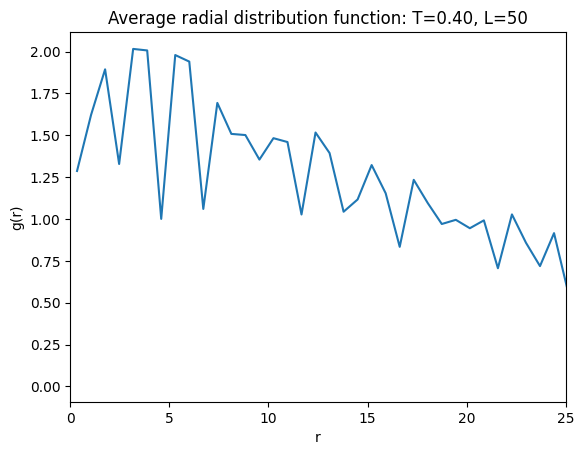

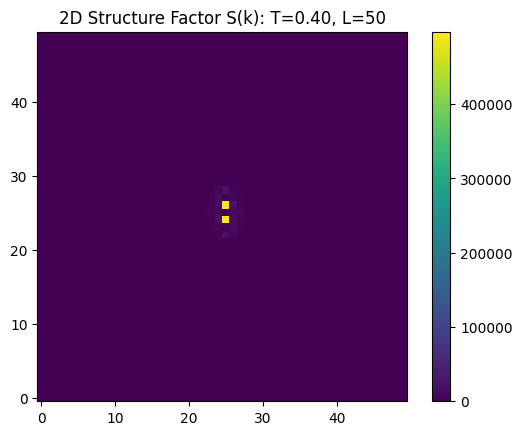

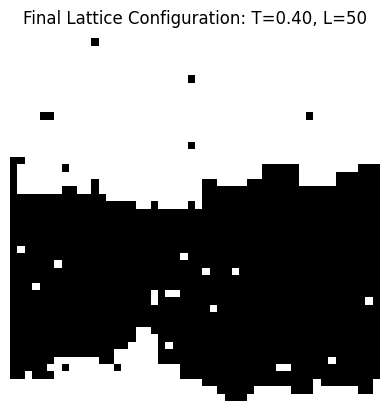

Acceptance rate: 0.5083


In [25]:
    # Plot and save results
    root_dir="./"
    os.makedirs(os.path.join(root_dir, "figures"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "data"), exist_ok=True)
    
    prefix = f"L{L}_rho{density:.2f}_T{T:.2f}"
   
    plt.figure()
    plt.plot(r_vals, g_avg)
    plt.xlim(0,L/2)
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.title(f"Average radial distribution function: T={T:.2f}, L={L:.0f}")
    plt.savefig(root_dir+f"figures/{prefix}_radial_distribution.pdf")
   
    plt.figure()
    plt.imshow(S_avg, origin="lower")
    plt.title(f"2D Structure Factor S(k): T={T:.2f}, L={L:.0f}")
    plt.colorbar()
    plt.savefig(root_dir + f"figures/{prefix}_structure_factor_2d.pdf")


    plt.figure()
    plt.imshow(lattice, cmap="gray")
    plt.axis("off")
    plt.title(f"Final Lattice Configuration: T={T:.2f}, L={L:.0f}")
    plt.savefig(root_dir + f"figures/{prefix}_final_lattice.pdf")
    plt.show()

    # Print final acceptance rate
    print(f"Acceptance rate: {total_accept / total_attempt:.4f}")